In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import sys

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# Define the Q-network model using PyTorch
class DQN(nn.Module):
    def __init__(self, state_shape, num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(self._conv2d_output(state_shape), 512)
        self.fc2 = nn.Linear(512, num_actions)

    def _conv2d_output(self, shape):
        x = torch.zeros(1, *shape)
        x = self._forward_conv(x)
        return int(np.prod(x.size()))

    def _forward_conv(self, x):
        x = nn.functional.relu(self.conv1(x), inplace=True)
        x = nn.functional.relu(self.conv2(x), inplace=True)
        x = nn.functional.relu(self.conv3(x), inplace=True)
        return x.view(x.size(0), -1)

    def forward(self, x):
        x = self._forward_conv(x)
        x = nn.functional.relu(self.fc1(x), inplace=True)
        x = self.fc2(x)
        return x

# Experience replay buffer
from collections import deque

class ReplayBuffer:
    def __init__(self, size=10000):
        self._maxsize = size
        self._storage = deque(maxlen=self._maxsize)

    def __len__(self):
        return len(self._storage)

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self._storage.append(data)

    def sample(self, batch_size):
        batch = random.sample(self._storage, batch_size)
        batch = np.array(batch, dtype=object)  # Convert to NumPy array

        states = np.array([obs[0] for obs in batch])
        actions = np.array([obs[1] for obs in batch])
        rewards = np.array([obs[2] for obs in batch])
        next_states = np.array([obs[3] for obs in batch])
        dones = np.array([obs[4] for obs in batch])

        states = torch.tensor(states).float().to(device)
        actions = torch.tensor(actions).long().to(device)
        rewards = torch.tensor(rewards).float().to(device)
        next_states = torch.tensor(next_states).float().to(device)
        dones = torch.tensor(dones).float().to(device)

        return states, actions, rewards, next_states, dones

In [3]:
# Initialize the environment
env = gym.make('BreakoutNoFrameskip-v4')
env = gym.wrappers.AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=True, noop_max=30)
env = gym.wrappers.FrameStack(env, num_stack=4)

state_dim = env.observation_space.shape
num_actions = env.action_space.n

print('State shape: ', env.observation_space)
print('Number of actions: ', num_actions)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


State shape:  Box(0.0, 1.0, (4, 84, 84), float32)
Number of actions:  4


In [4]:
# Instantiate the Q-network model and target model
model = DQN(state_dim, num_actions).to(device)
model_target = DQN(state_dim, num_actions).to(device)
model_target.load_state_dict(model.state_dict())
model

DQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

In [5]:
# Define other parameters and hyperparameters
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_max = 1.0
epsilon_interval = epsilon_max - epsilon_min
batch_size = 32
max_steps_per_episode = 10000
max_memory_length = 15000
replay_buffer = ReplayBuffer(max_memory_length)
optimizer = optim.Adam(model.parameters(), lr=0.00025)
loss_function = nn.HuberLoss()

episode_reward_history = np.array([])
running_reward = 0
episode_count = 0
frame_count = 0
epsilon_random_frames = 50000
epsilon_greedy_frames = 1000000.0
update_target_network = 10000

reward_history = np.array([])
frame_count_history = np.array([])
epsilon_history = np.array([])
best_reward = 0

In [6]:
while True:
    env.reset()
    state, _, done, _, _ = env.step(0)
    state = np.array(state, dtype=np.float32)
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        frame_count += 1

        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1):
            action = np.random.choice(num_actions)
            action = np.uint8(action)
        else:
            with torch.no_grad():
                state = np.array(state, dtype=np.float32)
                q_values = model(torch.tensor(state).unsqueeze(0).float().to(device))
                action = torch.argmax(q_values).item()
                action = np.uint8(action)

        if epsilon > epsilon_min:
            epsilon -= epsilon_interval / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min)

        next_state, reward, done, e, f = env.step(action)
        next_state =  np.array(next_state, dtype=np.float32)
        episode_reward += reward

        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state

        if len(replay_buffer) > batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

            future_rewards = model_target(next_states).max(1)[0]
            updated_q_values = rewards + gamma * future_rewards * (1 - dones)

            current_q_values = model(states)
            selected_q_values = current_q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

            loss = loss_function(updated_q_values, selected_q_values)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # To avoid biais de sur-estimation update the target network every update_target_network steps
        if frame_count % update_target_network == 0:
            model_target.load_state_dict(model.state_dict())

        if done:
            break

    episode_reward_history = np.append(episode_reward_history, episode_reward)
    running_reward = np.mean(episode_reward_history)

    if episode_count % 10 == 0:
        if len(episode_reward_history) > 100:
            episode_reward_history = np.delete(episode_reward_history, np.s_[:10])
        running_reward = np.mean(episode_reward_history)
        print("Episode {} reward: {} frame_count: {} epsilon: {} memory size: {}".format(episode_count, running_reward, frame_count, epsilon, len(replay_buffer)))
        reward_history = np.append(reward_history, running_reward)
        frame_count_history = np.append(frame_count_history, frame_count)
        epsilon_history = np.append(epsilon_history, epsilon)

    if running_reward > 5 and running_reward > best_reward:
        best_reward = running_reward
        torch.save(model.state_dict(), f"models/model_rew_{round(running_reward)}.pth")

    if running_reward > 40:
        print("Solved at episode {}!".format(episode_count))
        break

    episode_count += 1

Episode 0 reward: 0.0 frame_count: 133 epsilon: 0.9998803000000039 memory size: 133
Episode 10 reward: 1.4545454545454546 frame_count: 2128 epsilon: 0.998084800000063 memory size: 2128
Episode 20 reward: 1.3333333333333333 frame_count: 3976 epsilon: 0.9964216000001178 memory size: 3976
Episode 30 reward: 1.3225806451612903 frame_count: 5869 epsilon: 0.9947179000001739 memory size: 5869
Episode 40 reward: 1.3658536585365855 frame_count: 7729 epsilon: 0.993043900000229 memory size: 7729
Episode 50 reward: 1.3333333333333333 frame_count: 9578 epsilon: 0.9913798000002838 memory size: 9578
Episode 60 reward: 1.278688524590164 frame_count: 11279 epsilon: 0.9898489000003342 memory size: 11279
Episode 70 reward: 1.2816901408450705 frame_count: 13117 epsilon: 0.9881947000003887 memory size: 13117
Episode 80 reward: 1.3333333333333333 frame_count: 15108 epsilon: 0.9864028000004477 memory size: 15000
Episode 90 reward: 1.2857142857142858 frame_count: 16861 epsilon: 0.9848251000004996 memory size:

KeyboardInterrupt: 

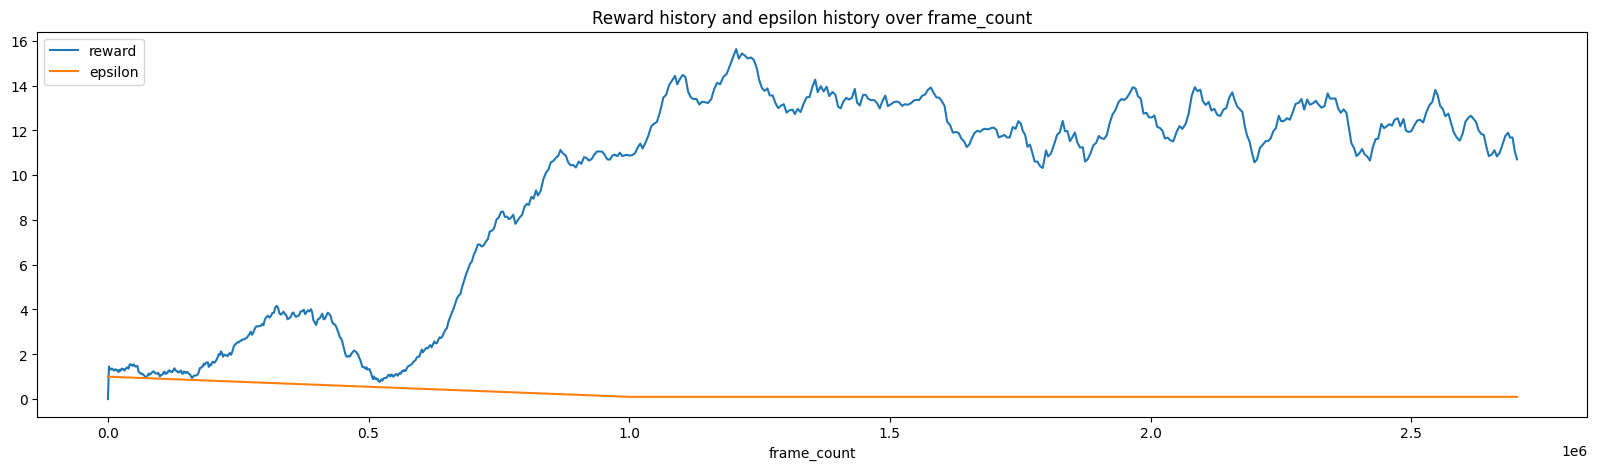

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(frame_count_history, reward_history)
plt.plot(frame_count_history, epsilon_history)
plt.title('Reward history and epsilon history over frame_count')
plt.xlabel('frame_count')
plt.legend(['reward', 'epsilon'], loc='upper left')
plt.show()

In [8]:
torch.save(model.state_dict(), 'models/model_weights.pth')

In [9]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import os

def create_video(env, model, folder="videos", name="video"):
    video_recorder = VideoRecorder(env, path=os.path.join(folder, name + ".mp4"))
    env.reset()
    s, _, done, _, _ = env.step(0)
    epoch = 0
    total_reward = 0

    while not done and epoch < 1000:
        video_recorder.capture_frame()
        s = np.array(s)
        action_probs = model(torch.tensor(s).unsqueeze(0).to(device))
        action = torch.argmax(action_probs).item()
        s, reward, done, _, _ = env.step(action)
        total_reward += reward
        epoch += 1

    video_recorder.close()
    return total_reward

In [10]:
env = gym.make('BreakoutNoFrameskip-v4', render_mode='rgb_array')
env = gym.wrappers.AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=True, noop_max=30)
env = gym.wrappers.FrameStack(env, num_stack=4)
create_video(env, model, folder="videos", name="video")

/home/coartix/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Moviepy - Building video videos/video.mp4.
Moviepy - Writing video videos/video.mp4



Moviepy - Done !
Moviepy - video ready videos/video.mp4


20.0

In [17]:
# Use model from models/model_rew_15.pth
model = DQN(state_dim, num_actions).to(device)
model.load_state_dict(torch.load("models/model_rew_16.pth"))

env = gym.make('BreakoutNoFrameskip-v4', render_mode='rgb_array')
env = gym.wrappers.AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, scale_obs=True, noop_max=30)
env = gym.wrappers.FrameStack(env, num_stack=4)
r = create_video(env, model, folder="videos", name="video")
print(f"Reward : {r}")

Moviepy - Building video videos/video.mp4.
Moviepy - Writing video videos/video.mp4



Moviepy - Done !
Moviepy - video ready videos/video.mp4
Reward : 29.0
